<a href="https://colab.research.google.com/github/ASAB-001/ai_media_scheduler/blob/main/ai_media_scheduler_app.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ----------------------------------------
# AI Media Scheduler - Smart Daily Rotator + Dashboard + Data Science Features
# ----------------------------------------
# Supports: Audio, Video, PDF (with AI summaries)
# Platform: Google Colab / Python Script
# ----------------------------------------

!pip install transformers PyPDF2 schedule matplotlib seaborn

import os
import time
import schedule
import threading
from datetime import datetime, timedelta
import pandas as pd
from PyPDF2 import PdfReader
from transformers import pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

# === SETUP ===
drive.mount('/content/drive')
user_folder = "/content/drive/MyDrive/MediaSchedulerApp"
os.makedirs(user_folder, exist_ok=True)

# === AI MODEL ===
summarizer = pipeline("summarization", model="t5-small", tokenizer="t5-small")

# === MEDIA LIBRARY ===
# Replace with your real files
media_schedule = [
    {"title": "Day 1", "path": "sample_audio1.mp3", "type": "audio"},
    {"title": "Day 2", "path": "sample_video.mp4", "type": "video"},
    {"title": "Day 3", "path": "sample_audio2.mp3", "type": "audio"},
    {"title": "Day 4", "path": "sample_document.pdf", "type": "pdf"},
    {"title": "Day 5", "path": "sample_audio3.mp3", "type": "audio"},
]    # Add more items...


# === HISTORY LOG ===
media_log = []

def log_action(item, result="Played", summary="", tags=[]):
    media_log.append({
        "title": item['title'],
        "type": item['type'],
        "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        "result": result,
        "summary": summary,
        "tags": ", ".join(tags)
    })

def show_log():
    if not media_log:
        print("\ud83d\udcec No history yet.")
    else:
        df = pd.DataFrame(media_log)
        display(df)

# === AI PDF SUMMARIZER ===
def extract_pdf_text(file_path, max_pages=5):
    reader = PdfReader(file_path)
    text = ""
    for i, page in enumerate(reader.pages):
        if i >= max_pages:
            break
        page_text = page.extract_text()
        if page_text:
            text += page_text
    return text

def summarize_pdf(file_path):
    text = extract_pdf_text(file_path)
    if len(text.strip()) < 100:
        return "PDF too short to summarize."
    input_text = text[:1000]
    summary = summarizer(input_text, max_length=100, min_length=30, do_sample=False)[0]['summary_text']
    return summary

def extract_tags(summary):
    keywords = summary.lower().split()[:5]
    return list(set(keywords))

# === PLAYBACK HANDLER ===
def handle_item(item):
    print(f"\n Playing {item['title']} ({item['type']})")
    if item['type'] == "pdf":
        summary = summarize_pdf(item['path'])
        tags = extract_tags(summary)
        print("\n AI Summary:\n", summary)
        print(" Tags:", tags)
        log_action(item, result="Summarized", summary=summary, tags=tags)
    else:
        print(f" Simulated Playing: {item['path']}")
        for i in range(3):
            print(f"...playing ({i+1}/3)")
            time.sleep(1)
        print(" Finished")
        log_action(item, result="Played")

# === DAILY ROTATION LOGIC ===
start_date = datetime(2025, 6, 19)  # Change to your starting day

def get_today_index():
    delta_days = (datetime.now().date() - start_date.date()).days
    return delta_days if delta_days < len(media_schedule) else None

def daily_task():
    idx = get_today_index()
    if idx is None:
        print(" All scheduled files have been played.")
    else:
        handle_item(media_schedule[idx])

# === SCHEDULER ===
schedule.clear()
schedule.every(1).minutes.do(daily_task)  # Use `.day.at('08:00')` for real time

print(" Scheduler set. Will run every minute (demo mode).")

def run_scheduler():
    while True:
        schedule.run_pending()
        time.sleep(1)

threading.Thread(target=run_scheduler).start()

# === DASHBOARD ===
def show_dashboard():
    if not media_log:
        print(" No activity to show.")
        return
    df = pd.DataFrame(media_log)
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['date'] = df['timestamp'].dt.date
    plt.figure(figsize=(12,6))
    sns.countplot(data=df, x='date', hue='type')
    plt.title("Media Summary by Date")
    plt.xlabel("Date")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# === DATA SCIENCE EXTRAS ===
def summary_stats():
    if not media_log:
        print(" No data available.")
        return
    df = pd.DataFrame(media_log)
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    print(" Summary Stats:")
    print("- Total sessions:", len(df))
    print("- Unique days used:", df['timestamp'].dt.date.nunique())
    print("- Media breakdown:\n", df['type'].value_counts())

def calculate_streak():
    df = pd.DataFrame(media_log)
    if df.empty:
        print(" Current streak: 0 days")
        return
    df['date'] = pd.to_datetime(df['timestamp']).dt.date
    df = df.drop_duplicates('date')
    streak = 0
    today = datetime.today().date()
    for i in range(len(df)):
        if (today - timedelta(days=i)) in df['date'].values:
            streak += 1
        else:
            break
    print(f" Current streak: {streak} days")

def recommend_next_type():
    df = pd.DataFrame(media_log)
    if df.empty:
        print(" Start with any type you like!")
    else:
        print(" Recommended type based on usage:", df['type'].mode()[0])

def export_usage():
    if not media_log:
        print(" No log to export.")
        return
    df = pd.DataFrame(media_log)
    export_path = f"{user_folder}/media_usage_log.csv"
    df.to_csv(export_path, index=False)
    print(f" Log saved to: {export_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Device set to use cpu


 Scheduler set. Will run every minute (demo mode).


,title,type,timestamp,result,summary,tags
0,Day 1,audio,2025-06-19 23:12:11,Played,,


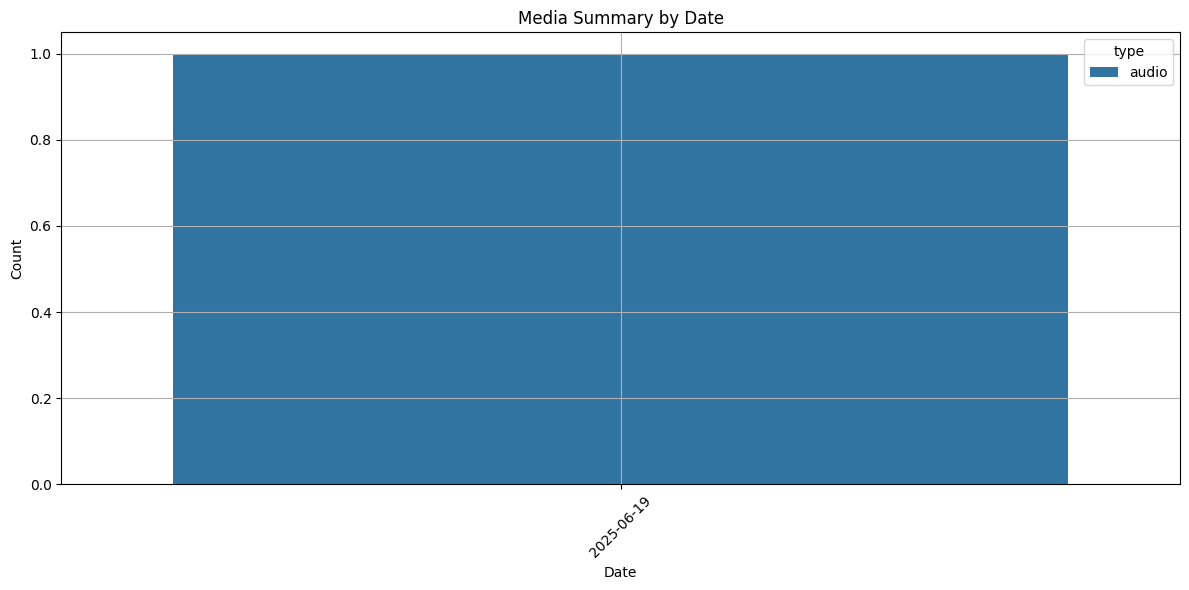

 Summary Stats:
- Total sessions: 1
- Unique days used: 1
- Media breakdown:
 type
audio    1
Name: count, dtype: int64
 Current streak: 1 days
 Recommended type based on usage: audio
 Log saved to: /content/drive/MyDrive/MediaSchedulerApp/media_usage_log.csv


In [4]:
show_log()
show_dashboard()
summary_stats()
calculate_streak()
recommend_next_type()
export_usage()